In [1]:
library(MASS)
library(nnet)
library(caret)
library(plotmo)
library(readr)
library(faraway)
library(ggplot2)
library(glmnet)
library(e1071)
library(randomForest)

Warning message:
"package 'nnet' was built under R version 3.6.3"Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'plotmo' was built under R version 3.6.2"Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos
Warning message:
"package 'TeachingDemos' was built under R version 3.6.2"Warning message:
"package 'readr' was built under R version 3.6.2"Warning message:
"package 'faraway' was built under R version 3.6.2"
Attaching package: 'faraway'

The following object is masked from 'package:lattice':

    melanoma

Warning message:
"package 'glmnet' was built under R version 3.6.2"Loading required package: Matrix
Loaded glmnet 3.0-2

Warning message:
"package 'e1071' was built under R version 3.6.2"randomForest 4.6-14
Type rfNews() to see new features/changes/

# Load Data and Final Clean

In [2]:
df <- read.csv(file="cleaned_data_0330.csv",sep=",",header=TRUE)
df = df[,-1]
dim(df)

[1] 2470   47

## Scale and center some variables:

In [4]:
mean_age = mean(df$Start_age)
sd_age = sd(df$Start_age)
df$s_start_age = round((df$Start_age - mean_age)/sd_age,5)
mean_net = mean(df$net_cost)
sd_net = sd(df$net_cost)
df$s_net_cost = round((df$net_cost - mean_net)/sd_net,5)
mean_year = mean(df$Start_year)
sd_year = sd(df$Start_year)
df$s_start_year = round((df$Start_year - mean_year)/sd_year,5)
av_net_cost = ifelse(df$Valid.term > 0, df$net_cost / df$Valid.term, df$net_cost)
av_mean_net = mean(av_net_cost)
av_sd_net = sd(av_net_cost)
df$avs_net_cost = round((av_net_cost - av_mean_net)/av_sd_net,5)
mean_Average.Precol.GPA = mean(df$Average.Precol.GPA)
sd_Average.Precol.GPA = sd(df$Average.Precol.GPA)
df$Precol.GPA = round((df$Average.Precol.GPA - mean_Average.Precol.GPA)/sd_Average.Precol.GPA,5)
mean_GRE.Combined.General.Write.Score = mean(df$GRE.Combined.General.Write.Score)
sd_GRE.Combined.General.Write.Score = sd(df$GRE.Combined.General.Write.Score)
df$GRE_Write = round((df$GRE.Combined.General.Write.Score - mean_GRE.Combined.General.Write.Score)/sd_GRE.Combined.General.Write.Score,5)
mean_GRE.Combined.Quantitative.Score = mean(df$GRE.Combined.Quantitative.Score)
sd_GRE.Combined.Quantitative.Score = sd(df$GRE.Combined.Quantitative.Score)
df$GRE.Quant = round((df$GRE.Combined.Quantitative.Score - mean_GRE.Combined.Quantitative.Score)/sd_GRE.Combined.Quantitative.Score,5)
mean_GRE.Combined.General.Verbal.Score = mean(df$GRE.Combined.General.Verbal.Score)
sd_GRE.Combined.General.Verbal.Score = sd(df$GRE.Combined.General.Verbal.Score)
df$GRE.Verbal = round((df$GRE.Combined.General.Verbal.Score - mean_GRE.Combined.General.Verbal.Score)/sd_GRE.Combined.General.Verbal.Score,5)
mean_GMAT.Score = mean(df$GMAT.Score)
sd_GMAT.Score = sd(df$GMAT.Score)
df$GMAT.Score = round((df$GMAT.Score - mean_GMAT.Score)/sd_GMAT.Score,5)
mean_gpa = mean(df$Average_GPA)
sd_gpa = sd(df$Average_GPA)
df$average_gpa = round((df$Average_GPA - mean_gpa)/sd_gpa,2)

In [5]:
# mean_SAPC1 = mean(df$SAPC1)
# sd_SAPC1 = sd(df$SAPC1)
# df$s_SAPC1 = (df$SAPC1 - mean_SAPC1)/sd_SAPC1
# mean_SAPC2 = mean(df$SAPC2)
# sd_SAPC2 = sd(df$SAPC2)
# df$s_SAPC2 = (df$SAPC2 - mean_SAPC2)/sd_SAPC2
# mean_SAPC3 = mean(df$SAPC3)
# sd_SAPC3 = sd(df$SAPC3)
# df$s_SAPC3 = (df$SAPC3 - mean_SAPC3)/sd_SAPC3

##  Add No GRE Indicator

In [6]:
df$has_gre = C(factor(ifelse(df$GRE.Quant == 0,1,0)),treatment)
df$has_gre1 = C(factor(ifelse(df$GRE.Quant == 0,0,1)),treatment)

## Seperate by School

Different Schools

In [7]:
schools = levels(factor(df$College))

In [8]:
Harpur_df = df[df$College %in% schools[1:4],]
Management_df = df[df$College=="GD Management",]
Nursing_df = df[df$College=="GD Nursing",]
Watson_df = df[df$College=="GD Watson",]

In [9]:
unique(Harpur_df$Major)

[1] Translation Studies            Chemistry                     
 [3] Behavioral Neuroscience        Cognitive Psychology          
 [5] Physics                        Mathematics                   
 [7] Comparative Literature         Educational Theory and Practic
 [9] Philosophy Interpretation and  Biological Sciences           
[11] English                        Materials Science and Engineer
[13] History                        Anthropology                  
[15] Sociology                      Material Sci and Eng-Engineerg
[17] Clinical Psychology            Economics                     
[19] Geology                        Philosophy SPEL               
[21] Political Science              Community and Public Affairs  
[23] Art History                    Materials Science and Engr    
[25] Biological Sciences EEB        X Geology                     
[27] Art History Combined MA PhD    Mechanical Engineering        
[29] Mathematics/Economics         
45 Levels: Anthropology Art History ... XGerontolog Clin Nurse Special

In [10]:
harpur_sciences <- c("Chemistry", "Behavioral Neuroscience","Cognitive Psychology","Physics","Mathematics",
                     "Biological Sciences","Materials Science and Engineer","Material Sci and Eng-Engineerg",
                     "Clinical Psychology","Economics","Geology","Political Science","Materials Science and Engr",
                     "Biological Sciences EEB", "X Geology","Mathematics/Economics")
harpur_arts <- c("Comparative Literature","Translation Studies","Educational Theory and Practic",
                 "Philosophy Interpretation and", "English","History","Anthropology","Sociology","Philosophy SPEL",
                 "Community and Public Affairs","Art History","Art History Combined MA PhD")

In [11]:
Harpur_sciences = Harpur_df[Harpur_df$Major %in% harpur_sciences,]
Harpur_arts = Harpur_df[Harpur_df$Major %in% harpur_arts,]

In [12]:
Harpur_sciences <- within(Harpur_sciences, Citizenship <- relevel(Citizenship, ref = "White"))
Harpur_arts <- within(Harpur_arts, Citizenship <- relevel(Citizenship, ref = "White"))
Management_df <- within(Management_df, Citizenship <- relevel(Citizenship, ref = "White"))
Watson_df <- within(Watson_df, Citizenship <- relevel(Citizenship, ref = "White"))
Nursing_df <- within(Nursing_df, Citizenship <- relevel(Citizenship, ref = "White"))

In [13]:
dim(Harpur_sciences)[1]
dim(Harpur_arts)[1]
dim(Harpur_df)[1]

[1] 861

[1] 918

[1] 1780

In [14]:
a_n = dim(Harpur_sciences)[1]
a_1 = sum(Harpur_sciences$Y)
a_0 = a_n - a_1
b_n = dim(Harpur_arts)[1]
b_1 = sum(Harpur_arts$Y)
b_0 = b_n - b_1
c_n = dim(Management_df)[1]
c_1 = sum(Management_df$Y)
c_0 = c_n - c_1
d_n = dim(Nursing_df)[1]
d_1 = sum(Nursing_df$Y)
d_0 = d_n - d_1
e_n = dim(Watson_df)[1]
e_1 = sum(Watson_df$Y)
e_0 = e_n - e_1
School = c("Harpur sciences","Harpur_arts","SOM","Nursing","Watson")
sch_total = c(a_n,b_n,c_n,d_n,e_n)
succ_total = c(a_1,b_1,c_1,d_1,e_1)
unsucc_total = c(a_0,b_0,c_0,d_0,e_0)
data.frame("School"=School,"Total"=sch_total,"Successful Graduates"=succ_total,"Unsuccessful Graduates"=unsucc_total)

School,Total,Successful.Graduates,Unsuccessful.Graduates
Harpur sciences,861,542,319
Harpur_arts,918,534,384
SOM,58,38,20
Nursing,117,72,45
Watson,515,343,172


In [15]:
Harpur_sciences$college_1 = 1
Harpur_arts$college_1 = 2
Management_df$college_1 = 5
Watson_df$college_1 = 3
Nursing_df$college_1 = 4
df1 = rbind(Harpur_sciences, Harpur_arts, Management_df, Watson_df, Nursing_df)

# Harpur Sciences Analysis

Won't use Degree column since it does not accurately show the student's major

<b> Logistic regression model:

In [241]:
log_mod_h_s = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_sciences,family="binomial")
# round(summary(log_mod_h_s)$coeff[which(summary(log_mod_h_s)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [242]:
log_mod_h_s_bic = stepAIC(log_mod_h_s, direction = "both", k = log(b_n),trace=0)

In [243]:
round(summary(log_mod_h_s_bic)$coeff[which(summary(log_mod_h_s_bic)$coef[,4] <= .05),c(1,4)],5)

,Estimate,Pr(>|z|)
s_start_year,-1.33439,0.00000
factor(funding_indicator)1,1.10597,0.00001
avs_net_cost,0.40391,0.00083
average_gpa,0.41468,0.00001


In [244]:
summary(log_mod_h_s_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost + average_gpa, family = "binomial", data = Harpur_sciences)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3969  -0.9619   0.5772   0.8600   2.2088  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.05770    0.21340  -0.270  0.78685    
s_start_year               -1.33439    0.12875 -10.364  < 2e-16 ***
factor(funding_indicator)1  1.10597    0.24726   4.473 7.72e-06 ***
avs_net_cost                0.40391    0.12083   3.343  0.00083 ***
average_gpa                 0.41468    0.09543   4.345 1.39e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1135.18  on 860  degrees of freedom
Residual deviance:  962.76  on 856  degrees of freedom
AIC: 972.76

Number of Fisher Scoring iterations: 4


# Harpur Arts Analysis

<b> Logistic regression model:

In [245]:
log_mod_h_a = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Harpur_arts,family="binomial")

<b> Both AIC:

In [246]:
# log_mod_h_a_aic = stepAIC(log_mod_h_a, direction = 'both')
# round(summary(log_mod_h_a_aic)$coeff[which(summary(log_mod_h_a_aic)$coef[,4] <= .05),c(1,4)],5)

<b> Both BIC

In [247]:
log_mod_h_a_bic = stepAIC(log_mod_h_a, direction = "both", k = log(b_n),trace=0)

<b> Significant variables both BIC selects:

In [248]:
summary(log_mod_h_a_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    average_gpa + factor(has_gre), family = "binomial", data = Harpur_arts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8295  -1.1350   0.7538   0.9647   1.8477  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.74585    0.18548  -4.021 5.79e-05 ***
s_start_year               -0.25131    0.08054  -3.120 0.001806 ** 
factor(funding_indicator)1  0.67883    0.17227   3.941 8.13e-05 ***
average_gpa                 0.31227    0.09436   3.309 0.000935 ***
factor(has_gre)1            0.89446    0.18848   4.746 2.08e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1248.0  on 917  degrees of freedom
Residual deviance: 1158.9  on 913  degrees of freedom
AIC: 1168.9

Number of Fisher Scoring iterations: 4


# Management Analysis

<b> Logistic regression model:

In [249]:
log_mod_m = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Management_df,family="binomial")

<b> Both BIC:

In [250]:
log_mod_m_bic = stepAIC(log_mod_m, direction = "both", k = log(c_n),trace=0)

<b> Significant variables both BIC selects:

In [251]:
round(summary(log_mod_m_bic)$coeff[which(summary(log_mod_m_bic)$coef[,4] <= .05),c(1,4)],5)
summary(log_mod_m_bic)

,Estimate,Pr(>|z|)
(Intercept),-2.62893,0.00680
s_start_age,2.00724,0.02719
average_gpa,7.07830,0.00028
factor(has_gre)1,3.13347,0.00263



Call:
glm(formula = Y ~ s_start_age + average_gpa + factor(has_gre), 
    family = "binomial", data = Management_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1868  -0.5733   0.2320   0.5893   1.9024  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.6289     0.9714  -2.706 0.006803 ** 
s_start_age        2.0072     0.9087   2.209 0.027186 *  
average_gpa        7.0783     1.9458   3.638 0.000275 ***
factor(has_gre)1   3.1335     1.0416   3.008 0.002626 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 74.726  on 57  degrees of freedom
Residual deviance: 41.303  on 54  degrees of freedom
AIC: 49.303

Number of Fisher Scoring iterations: 6


# Nursing Analysis

<b> Logistic regression model:

In [252]:
log_mod_n = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Nursing_df,family="binomial")

<b> Both BIC:

In [253]:
log_mod_n_bic = stepAIC(log_mod_n, direction = "both", k = log(d_n),trace=0)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [254]:
summary(log_mod_n_bic)


Call:
glm(formula = Y ~ s_start_year + average_gpa + factor(has_gre1), 
    family = "binomial", data = Nursing_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1675  -1.0764   0.3518   0.9639   2.4148  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)          0.5469     0.2602   2.102  0.03557 * 
s_start_year        -0.7407     0.2732  -2.711  0.00671 **
average_gpa          0.6010     0.3179   1.890  0.05871 . 
factor(has_gre1)1   17.4553  1181.6295   0.015  0.98821   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 155.91  on 116  degrees of freedom
Residual deviance: 126.66  on 113  degrees of freedom
AIC: 134.66

Number of Fisher Scoring iterations: 16


# Watson Analysis 

<b> Logistic regression model:

In [255]:
log_mod_w = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+factor(has_gre1)*GRE_Write+factor(has_gre1)*GRE.Quant+factor(has_gre1)*GRE.Verbal,
                data=Watson_df,family="binomial")

<b> Both BIC:

In [256]:
log_mod_w_bic = stepAIC(log_mod_w, direction = "both", k = log(e_n),trace=0)

<b> Significant variables both BIC selects:

In [257]:
summary(log_mod_w_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost, family = "binomial", data = Watson_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8893  -0.9101   0.5567   0.8484   1.7719  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.5034     0.2001  -2.516   0.0119 *  
s_start_year                -1.0004     0.1437  -6.963 3.34e-12 ***
factor(funding_indicator)1   2.0988     0.2644   7.939 2.04e-15 ***
avs_net_cost                 0.3515     0.1548   2.270   0.0232 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.07  on 514  degrees of freedom
Residual deviance: 551.63  on 511  degrees of freedom
AIC: 559.63

Number of Fisher Scoring iterations: 4


In [258]:
yyy = mean(df$s_start_year)
fi = 0
cost = mean(df$avs_net_cost)
ggg = data.frame("s_start_year"=yyy,"funding_indicator"=fi,"avs_net_cost"=cost)
predict(log_mod_w_bic, newdata=ggg,type="response")

1 
0.3767468

In [259]:
predict(log_mod_w_bic, newdata=ggg,type="response")

1 
0.3767468

In [260]:
(odds = exp(.2))
(odds)/(1+odds)

[1] 1.221403

[1] 0.549834

In [261]:
sd(df$Average_GPA)

[1] 0.7789857

# Joint Analysis

<b> Logistic regression model:

In [262]:
# int_chn = function(x) ifelse(x=='China',1,0)
# int_afc = function(x) ifelse(x=='Africa',1,0)
# int_asia = function(x) ifelse(x=='Asia',1,0)
# df <- within(df, s_Citizenship <- relevel(s_Citizenship, ref = "White"))
# df <- within(df, s_College <- relevel(s_College, ref = "GD Non-Harpur"))

In [263]:
df1$Citizenship = C(df1$Citizenship,sum)
df1$college <- C(factor(df1$college_1),sum)

In [264]:
df1$ha_wa = C(factor(ifelse(df1$college_1 %in% c(1,5),1,0)),sum)
df1$is_som = C(factor(ifelse(df1$college_1 == 3,1,0)),sum)
df1$a_s_n = C(factor(ifelse(df1$college_1 %in% c(2,3,4),1,0)),sum)
df1$is_nurse = C(factor(ifelse(df1$college_1 == 4,1,0)),sum)

In [265]:
df1$has_gre = C(df1$has_gre,treatment)

In [266]:
log_mod_total = glm(Y~s_start_age+factor(Gender)+s_start_year+factor(funding_indicator)+factor(Citizenship)+
                avs_net_cost+Precol.GPA+ factor(gap_indicator)+GPA_trend+average_gpa+
                +factor(has_gre)+GRE_Write+GRE.Quant+GRE.Verbal+college,
                data=df1,family="binomial")

<b> Both BIC:

In [267]:
log_mod_total_bic = stepAIC(log_mod_total, direction = "both", k = log(e_n),trace=0)

<b>Significant variables both BIC selects:

In [268]:
summary(log_mod_total_bic)


Call:
glm(formula = Y ~ s_start_year + factor(funding_indicator) + 
    avs_net_cost + Precol.GPA + GPA_trend + average_gpa + factor(has_gre) + 
    GRE_Write + college, family = "binomial", data = df1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5970  -1.0903   0.6496   0.9174   2.1561  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.351975   0.144814  -2.431  0.01508 *  
s_start_year               -0.595698   0.067106  -8.877  < 2e-16 ***
factor(funding_indicator)1  0.966458   0.117345   8.236  < 2e-16 ***
avs_net_cost                0.154880   0.048185   3.214  0.00131 ** 
Precol.GPA                  0.131529   0.046570   2.824  0.00474 ** 
GPA_trend                   0.875739   0.272290   3.216  0.00130 ** 
average_gpa                 0.337687   0.051908   6.505 7.75e-11 ***
factor(has_gre)1            0.496923   0.120302   4.131 3.62e-05 ***
GRE_Write                  -0.136074   0.04599

In [269]:
-.006 + .41 -.23 -.22

[1] -0.046

# Prediction

In [16]:
df_save = df

In [82]:
df = df_save

In [83]:
colnames(df)

[1] "X1st_Term_Funding"                 "X2nd_Term_Funding"                
 [3] "X3rd_Term_Funding"                 "X4th_Term_Funding"                
 [5] "Start_year"                        "Start_age"                        
 [7] "College"                           "Age"                              
 [9] "Degree"                            "Gender"                           
[11] "funding_indicator"                 "ID"                               
[13] "Citizenship"                       "Major_id"                         
[15] "Major"                             "net_cost"                         
[17] "Program"                           "Prep.Level"                       
[19] "Total.Charges"                     "Total.Funding.Amount"             
[21] "Y"                                 "PC1"                              
[23] "PC2"                               "PC3"                              
[25] "Term.1.GPA"                        "Term.2.GPA"                       
[27] "Term.3.GPA"                        "Term.4.GPA"                       
[29] "Term.5.GPA"                        "Term.6.GPA"                       
[31] "Term.7.GPA"                        "Term.8.GPA"                       
[33] "gap_indicator"                     "GPA_trend"                        
[35] "Valid.term"                        "Average_GPA"                      
[37] "academic_period"                   "s_College"                        
[39] "s_Citizenship"                     "SAPC1"                            
[41] "SAPC2"                             "SAPC3"                            
[43] "Average.Precol.GPA"                "GMAT.Score"                       
[45] "GRE.Combined.General.Write.Score"  "GRE.Combined.Quantitative.Score"  
[47] "GRE.Combined.General.Verbal.Score" "s_start_age"                      
[49] "s_net_cost"                        "s_start_year"                     
[51] "avs_net_cost"                      "Precol.GPA"                       
[53] "GRE_Write"                         "GRE.Quant"                        
[55] "GRE.Verbal"                        "average_gpa"                      
[57] "has_gre"                           "has_gre1"

In [84]:
column_to_keep_name = c('Y','has_gre','Gender','Average_GPA','s_start_year','s_Citizenship','avs_net_cost','Gender','s_Average.Precol.GPA','s_GRE.Combined.General.Write.Score','s_GRE.Combined.Quantitative.Score','s_GRE.Combined.General.Verbal.Score','College','funding_indicator','Citizenship','gap_indicator','GPA_trend')
column_to_keep = NULL
for (i in 1:length(column_to_keep_name)){
    column_to_keep = c(column_to_keep,which(colnames(df)==column_to_keep_name[i]))
}

In [85]:
df = df[,column_to_keep]
colnames(df)

[1] "Y"                 "Gender"            "Average_GPA"      
 [4] "s_start_year"      "s_Citizenship"     "avs_net_cost"     
 [7] "Gender.1"          "College"           "funding_indicator"
[10] "Citizenship"       "gap_indicator"     "GPA_trend"

In [86]:
set.seed(123)
s1 = sample(nrow(df),0.5*nrow(df))
train = df[s1,]
non_train = df[-s1,]
s2 = sample(nrow(non_train),0.5*nrow(non_train))
test = non_train[s2,]
vld = non_train[-s2,]

train_y=train[,1]
train_x=train[,-1]
test_y=test[,1]
test_x=test[,-1]
vld_y=vld[,1]
vld_x=vld[,-1]
dim(train)
dim(test)

[1] 1235   12

[1] 617  12

## Random Forest

In [87]:
library("randomForest")
n<-length(names(train)) 
rate=1
for(i in 1:(n-1)){
  set.seed(1234)
  rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=i,ntree=1000)
  rate[i]<-mean(rf_train$err.rate)  
  print(rf_train)    
}


Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 1

        OOB estimate of  error rate: 30.85%
Confusion matrix:
   0   1 class.error
0 85 377 0.816017316
1  4 769 0.005174644

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 22.02%
Confusion matrix:
    0   1 class.error
0 243 219  0.47402597
1  53 720  0.06856404

Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = train,      mtry = i, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 22

[1] 0.3714918 0.2590767 0.2538966 0.2569892 0.2631100 0.2626135 0.2613012
 [8] 0.2628758 0.2639718 0.2662272 0.2652474

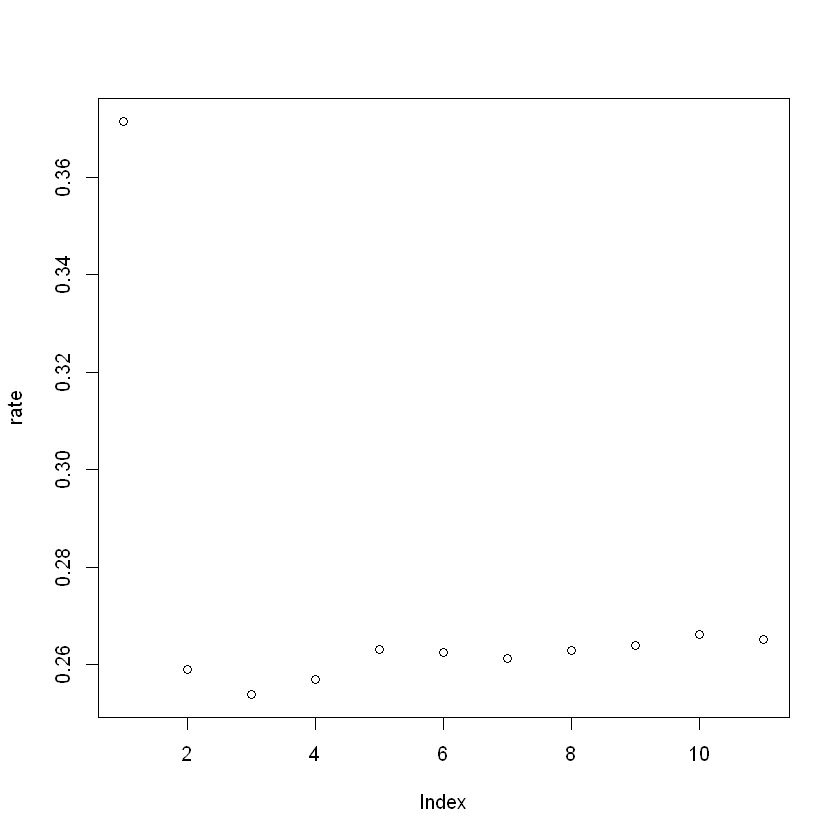

In [88]:
rate  
plot(rate)

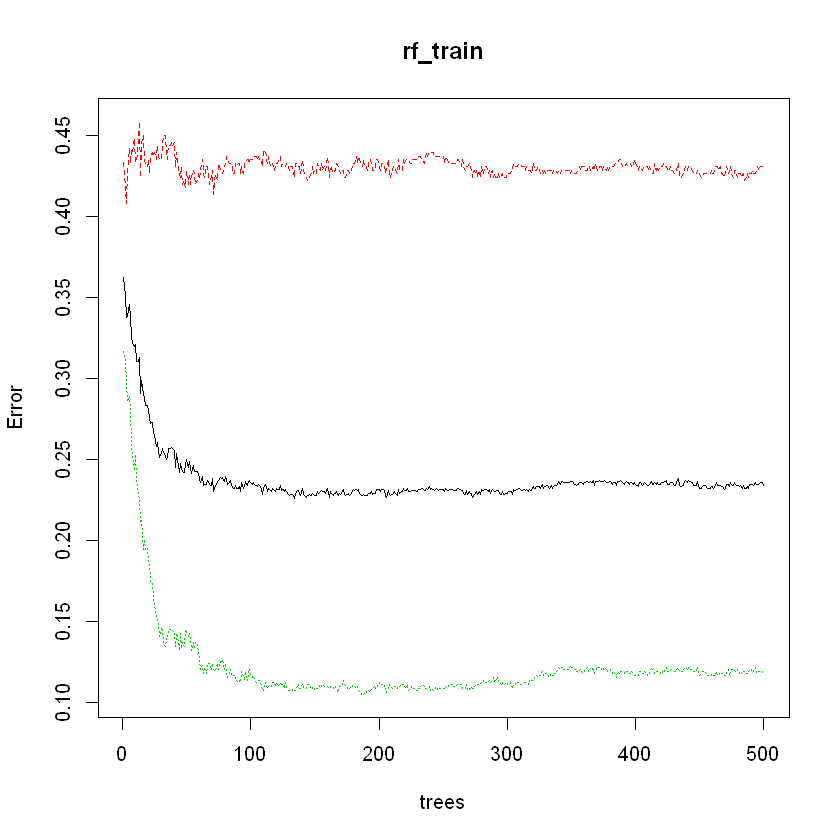

In [89]:
rf_train<-randomForest(as.factor(train$Y)~.,data=train,mtry=6)
plot(rf_train)    
legend(800,0.02,"Y=0",cex=0.9,bty="n")    
legend(800,0.0245,"total",cex=0.09,bty="n")   

In [90]:
set.seed(100)
rf_train<-randomForest(as.factor(train$Y)~.,data=as.data.frame(train),mtry = 6,importance=TRUE)
rf_train


Call:
 randomForest(formula = as.factor(train$Y) ~ ., data = as.data.frame(train),      mtry = 6, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 23.48%
Confusion matrix:
    0   1 class.error
0 260 202   0.4372294
1  88 685   0.1138422

In [112]:
rf_pred = predict(rf_train, newdata = test)
(rf_acc = round(sum(rf_pred == test$Y)/length(rf_pred),4))

rf_pred_0 = predict(rf_train, newdata = test[which(test$Y==0),])
(rf_acc_0 = round(sum(rf_pred_0 == test[which(test$Y==0),]$Y)/length(rf_pred_0),4))

[1] 0.7439

[1] 0.5238

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
Gender,1.83945571,1.453851,2.247034,8.183536
Average_GPA,27.01567670,38.495441,46.130391,128.848880
s_start_year,39.65880857,41.371856,55.117245,116.261943
s_Citizenship,6.52298389,2.362087,6.591420,9.119808
avs_net_cost,15.84273421,16.336410,22.865575,119.985945
Gender.1,0.03438877,3.615311,3.103212,7.980053
College,5.09016029,11.020521,12.054519,28.680317
funding_indicator,7.60712672,9.083225,12.654329,13.950032
Citizenship,13.95572638,3.006571,10.554609,57.648599
gap_indicator,9.92119770,2.361415,8.027408,9.695792


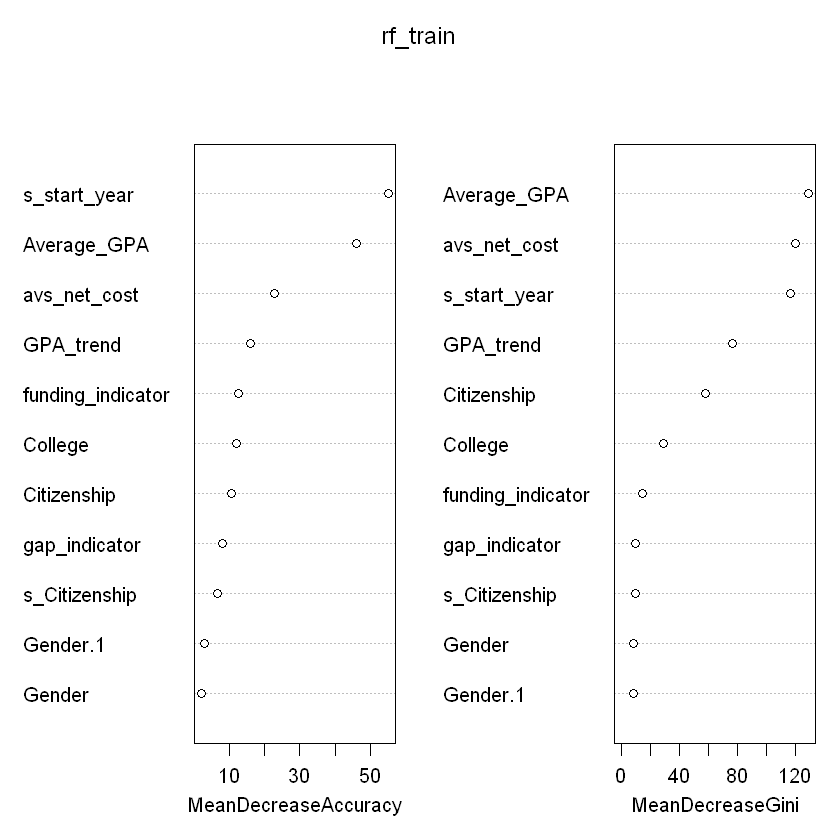

In [92]:
importance(rf_train)
varImpPlot(rf_train)

## LDA

In [113]:
mod_lda = lda(Y~., data = as.data.frame(train))
lda_pred = predict(mod_lda, newdata = test)
(lda_acc = round(sum(lda_pred$class == test$Y)/length(lda_pred$class),4))

lda_pred_0 = predict(mod_lda, newdata = test[which(test$Y==0),])
(lda_acc_0 = round(sum(lda_pred_0$class == test[which(test$Y==0),]$Y)/length(lda_pred_0$class),4))

Warning message in lda.default(x, grouping, ...):
"variables are collinear"

[1] 0.6985

[1] 0.3636

[1] 0.3636

<b> Summary

In [95]:
mod_lda$scaling

,LD1
GenderMale,0.15489471
Average_GPA,0.62613795
s_start_year,-0.76647329
s_CitizenshipAsia,-0.29306484
s_CitizenshipChina,-0.40689664
s_CitizenshipWhite,-0.81745497
avs_net_cost,0.10594239
Gender.1Male,0.15489471
CollegeGD Education,0.19635038
CollegeGD Grad School,2.60060403


## Neural Network

In [96]:
nnet_vld = NULL
for (i in seq(1,10,1)){
    mod_nnet = nnet(Y~., data = train, size  = i,trace = FALSE, decay =.1, rang = 0, maxit = 250)
    nn_pred = predict(mod_nnet, newdata = vld)
    nn_pred = as.numeric(nn_pred>=.5)
    nnet_vld = c(nnet_vld, sum(nn_pred == vld$Y)/length(nn_pred))
}
(tr_size = which.max(nnet_vld))

[1] 1

In [116]:
mod_nnet = nnet(Y~., data = train, size  = tr_size,trace = FALSE, decay =.1, rang = 0, maxit = 250)

nn_pred = as.numeric(predict(mod_nnet, newdata = test)>= .5)
(nnet_acc = round(sum(nn_pred == test$Y)/length(nn_pred),4))

nn_pred_0 = as.numeric(predict(mod_nnet, newdata = test[which(test$Y==0),])>= .5)
(nnet_acc_0 = round(sum(nn_pred_0 == test[which(test$Y==0),]$Y)/length(nn_pred_0),4))

[1] 0.7261

[1] 0.4459

<b> Summary

In [99]:
summary(mod_nnet)

a 27-1-1 network with 30 weights
options were - decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -4.17    0.15    1.63   -0.76   -0.41   -0.51   -1.16    0.12    0.15   -0.77 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 i19->h1 
   5.14   -0.90   -0.52   -0.13   -0.58    0.58   -0.41   -0.39    0.23   -0.51 
i20->h1 i21->h1 i22->h1 i23->h1 i24->h1 i25->h1 i26->h1 i27->h1 
  -0.17   -0.25    0.05   -0.21   -0.29   -0.14    0.58    1.33 
 b->o h1->o 
-2.82  5.45 

## Logistic Regression

In [118]:
mod_glm = glm(Y~., data = train, family=binomial())

glm_pred = as.numeric(predict(mod_glm, newdata = test, type="response") >= .5)
(glm_acc = round(sum(glm_pred == test$Y)/length(glm_pred),4))

glm_pred_0 = as.numeric(predict(mod_glm, newdata = test[which(test$Y==0),], type="response") >= .5)
(glm_acc_0 = round(sum(glm_pred_0 == test[which(test$Y==0),]$Y)/length(glm_pred_0),4))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

[1] 0.7034

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

[1] 0.3939

<b> Summary

In [102]:
summary(mod_glm)


Call:
glm(formula = Y ~ ., family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4905  -1.0664   0.6315   0.8957   2.6185  

Coefficients: (4 not defined because of singularities)
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.438260   0.945203  -1.522  0.12810
GenderMale                               0.271171   0.139431   1.945  0.05179
Average_GPA                              0.647120   0.118585   5.457 4.84e-08
s_start_year                            -0.733247   0.087388  -8.391  < 2e-16
s_CitizenshipAsia                       -0.642480   0.588950  -1.091  0.27532
s_CitizenshipChina                      -0.844128   0.587897  -1.436  0.15105
s_CitizenshipWhite                      -1.158975   0.562025  -2.062  0.03919
avs_net_cost                             0.104691   0.066032   1.585  0.11286
Gender.1Male                                   NA         NA     

## SVM

In [119]:
mod_svm = svm(Y~., data = train, family=binomial())

svm_pred = as.numeric(predict(mod_svm, newdata = test, type="response") >= .5)
(svm_acc = round(sum(svm_pred == test$Y)/length(svm_pred),4))

svm_pred_0 = as.numeric(predict(mod_svm, newdata = test[which(test$Y==0),], type="response") >= .5)
(svm_acc_0 = round(sum(svm_pred_0 == test[which(test$Y==0),]$Y)/length(svm_pred_0),4))

[1] 0.7066

[1] 0.2814

<b> Summary

In [105]:
summary(mod_svm)
colMeans(mod_svm$SV)
#The resulting support vectors (possibly scaled).


Call:
svm(formula = Y ~ ., data = train, family = binomial())


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03571429 
    epsilon:  0.1 


Number of Support Vectors:  996






GenderFemale                              GenderMale 
                            0.468875502                             0.531124498 
                            Average_GPA                            s_start_year 
                           -0.055698529                             0.102678336 
                      s_CitizenshipAsia                      s_CitizenshipChina 
                            0.129518072                             0.130522088 
                     s_CitizenshipWhite                            avs_net_cost 
                            0.715863454                             0.024507645 
                           Gender.1Male                     CollegeGD.Education 
                            0.531124498                             0.029116466 
                  CollegeGD.Grad.School                        CollegeGD.Harpur 
                            0.023092369                             0.661646586 
                   CollegeGD.Management                       CollegeGD.Nursing 
                            0.023092369                             0.049196787 
                       CollegeGD.Watson                       funding_indicator 
                            0.200803213                            -0.023230649 
                        CitizenshipAsia                        CitizenshipAsian 
                            0.129518072                             0.042168675 
   CitizenshipBlack.or.African.American                        CitizenshipChina 
                            0.033132530                             0.130522088 
                      CitizenshipEurope           CitizenshipHispanic.or.Latino 
                            0.021084337                             0.040160643 
                       CitizenshipIndia CitizenshipOther.International.Students 
                            0.044176707                             0.018072289 
                     CitizenshipUnknown                        CitizenshipWhite 
                            0.071285141                             0.445783133 
                          gap_indicator                               GPA_trend 
                           -0.027831189                            -0.005629228

## LASSO

In [106]:
train_x = model.matrix(~., data = train_x)
test_x = model.matrix(~., data = test_x)

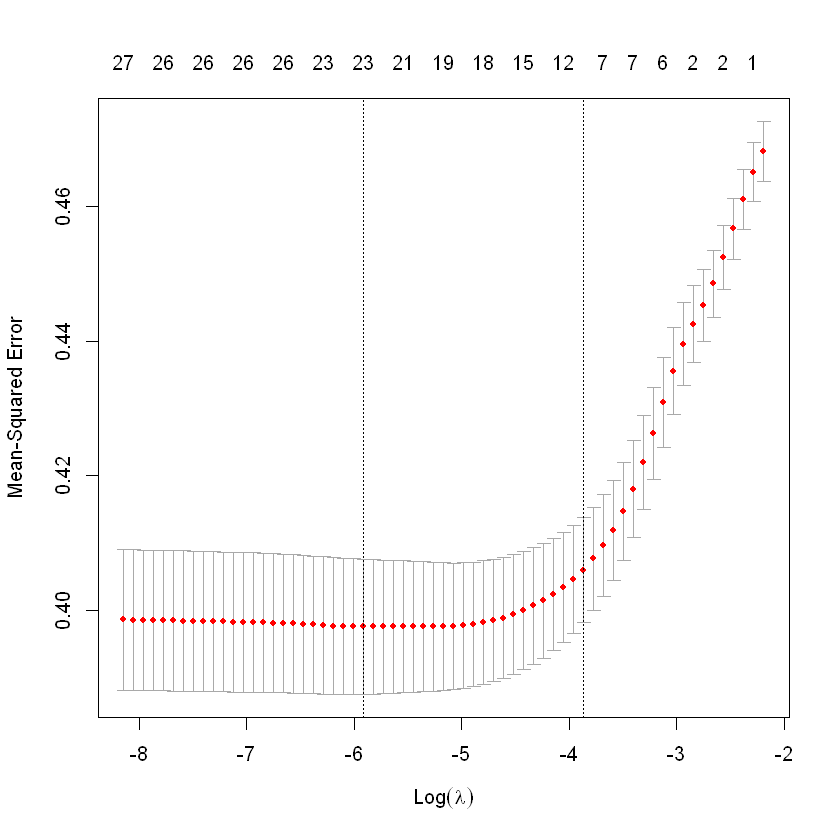

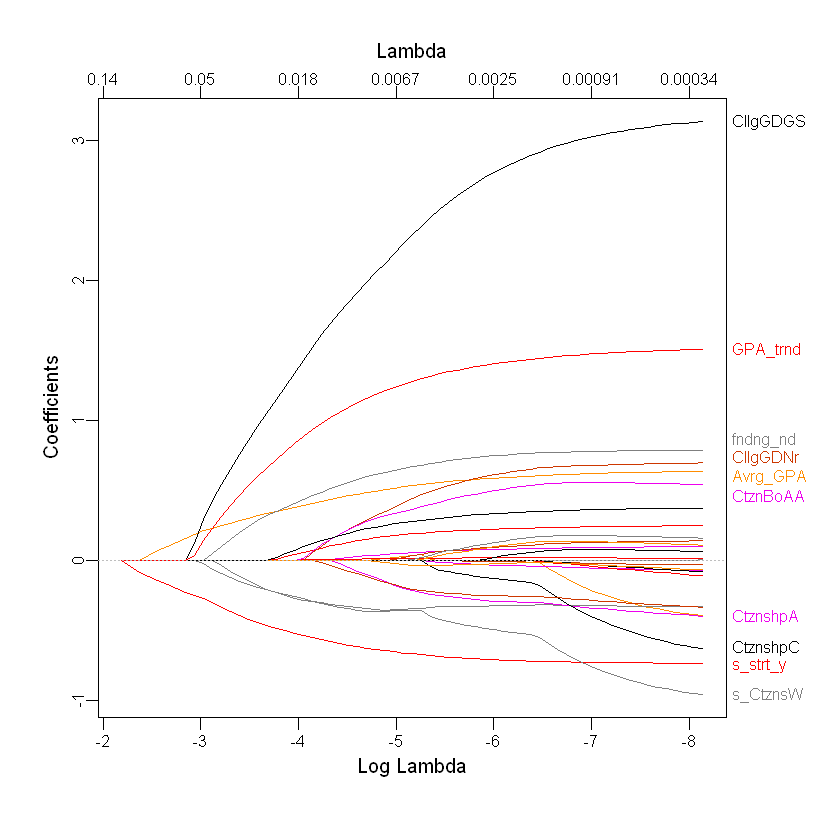

In [107]:
cvfit = cv.glmnet(train_x,train_y,alpha=1,family='binomial',type.measure='mse')
mod_lasso = glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda)
plot(cvfit)
plot_glmnet(mod_lasso)
mod_lasso <- glmnet(train_x,train_y,alpha=1, family = "binomial",lambda = cvfit$lambda.min)

In [120]:
lasso_pred = predict(mod_lasso, test_x, type="class")
lasso_right = colSums(lasso_pred == test_y)
(lasso_acc = round(max(lasso_right)/length(test_y),4))

lasso_pred_0 = predict(mod_lasso, test_x[which(test_y==0),], type="class")
lasso_right_0 = colSums(lasso_pred_0 == test_y[which(test_y==0)])
(lasso_acc_0 = round(max(lasso_right_0)/length(test_y[which(test_y==0)]),4))

[1] 0.7115

[1] 0.3853

<b> Summary

In [109]:
mod_lasso$beta

28 x 1 sparse Matrix of class "dgCMatrix"
                                                 s0
(Intercept)                              .         
GenderMale                               0.04996738
Average_GPA                              0.58559673
s_start_year                            -0.70276364
s_CitizenshipAsia                        .         
s_CitizenshipChina                       .         
s_CitizenshipWhite                      -0.48178187
avs_net_cost                             0.07937981
Gender.1Male                             0.19386417
CollegeGD Education                      .         
CollegeGD Grad School                    2.74016484
CollegeGD Harpur                        -0.31775359
CollegeGD Management                     .         
CollegeGD Nursing                        0.60490337
CollegeGD Watson                         0.09717412
funding_indicator                        0.74266628
CitizenshipAsia                          .         
CitizenshipAsian      

## Prediction Summary

In [110]:
res = data.frame(rbind(rf_acc, lda_acc, nnet_acc, glm_acc,svm_acc,lasso_acc))
colnames(res) = 'Accuracy'
rownames(res) = c('Random Forest','LDA', 'Neural Network', 'Logistic Regression', 'SVM', 'LASSO')
res

,Accuracy
Random Forest,0.5238
LDA,0.3636
Neural Network,0.4459
Logistic Regression,0.3939
SVM,0.2814
LASSO,0.3853


In [121]:
res_0 = data.frame(rbind(rf_acc_0, lda_acc_0, nnet_acc_0, glm_acc_0,svm_acc_0,lasso_acc_0))
colnames(res_0) = 'Accuracy On Unsuccessful Students'
rownames(res_0) = c('Random Forest','LDA', 'Neural Network', 'Logistic Regression', 'SVM', 'LASSO')
res_0

,Accuracy On Unsuccessful Students
Random Forest,0.5238
LDA,0.3636
Neural Network,0.4459
Logistic Regression,0.3939
SVM,0.2814
LASSO,0.3853


In [111]:
odds = exp(1.35*5)
p = (odds)/(1+odds)
odds

[1] 854.0588